Implemented from http://afni.nimh.nih.gov/pub/dist/src/pkundu/README.meica

In [1]:
import numpy as np
from scipy import misc
from scipy import ndimage

In [2]:
from tempfile import TemporaryFile
#~ Create a memmap with dtype and shape that matches our data for memory saving
tmpFn = TemporaryFile()
# result = np.memmap(tmpFn, dtype='float64', mode='w+', shape=output_raw_shape)

In [3]:
from volumeutils import array_to_file, array_from_file, calculate_scale, apply_read_scaling, apply_write_scaling

In [4]:
data = misc.lena().astype(np.float64)*13.87686959
data = ndimage.zoom(data, 30, order=0)

# data = np.random.random((1e3,1e3))
output_raw_shape = data.shape
print data.nbytes/(2**20)
print data.dtype

1800
float64


In [5]:
scaling, intercept, mn, mx = calculate_scale(data, np.int8, True)

In [6]:
print scaling, intercept, mn, mx

13.3326787949 1706.58288574 0.0 3399.83304955


In [7]:
# array_to_file(data, tmpFn, np.int8, intercept=intercept, divslope=scaling)
# data2 = array_from_file(output_raw_shape, np.int8, tmpFn)

data2 = apply_write_scaling(data, np.int8, intercept=intercept, divslope=scaling)

print data2.nbytes/(2**20)
print data2.dtype

data2 = data2.astype(np.float64)
data2 = apply_read_scaling(data2, scaling, intercept)

225
int8


In [8]:
print data.min(), data2.min(), data.max(), data2.max(), data.mean(), data2.mean()

0.0 0.0 3399.83304955 3399.83309269 1721.40789771 1721.24973581


In [9]:
print data
print data2

[[ 2248.05287358  2248.05287358  2248.05287358 ...,  1776.23930752
   1776.23930752     0.        ]
 [ 2248.05287358  2248.05287358  2248.05287358 ...,  1776.23930752
   1776.23930752     0.        ]
 [ 2248.05287358  2248.05287358  2248.05287358 ...,  1776.23930752
   1776.23930752     0.        ]
 ..., 
 [  610.58226196   610.58226196   610.58226196 ...,  1498.70191572
   1498.70191572     0.        ]
 [  610.58226196   610.58226196   610.58226196 ...,  1498.70191572
   1498.70191572     0.        ]
 [    0.             0.             0.         ...,     0.             0.
      0.        ]]
[[ 2253.22271633  2253.22271633  2253.22271633 ...,  1773.24627972
   1773.24627972     0.        ]
 [ 2253.22271633  2253.22271633  2253.22271633 ...,  1773.24627972
   1773.24627972     0.        ]
 [ 2253.22271633  2253.22271633  2253.22271633 ...,  1773.24627972
   1773.24627972     0.        ]
 ..., 
 [  613.30322456   613.30322456   613.30322456 ...,  1493.26002502
   1493.26002502     0.   

In [10]:
%matplotlib inline
import matplotlib.pylab as plt

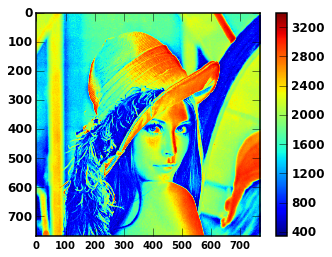

In [11]:
plt.imshow(data2[::20,::20])
plt.colorbar()

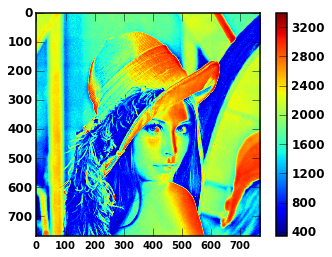

In [12]:
plt.imshow(data[::20,::20])
plt.colorbar()

In [ ]:
def finite_range(arr):
    ''' Return range (min, max) of finite values of ``arr``

    Parameters
    ----------
    arr : array

    Returns
    -------
    mn : scalar
       minimum of values in (flattened) array
    mx : scalar
       maximum of values in (flattened) array

    Examples
    --------
    >>> a = np.array([[-1, 0, 1],[np.inf, np.nan, -np.inf]])
    >>> finite_range(a)
    (-1.0, 1.0)
    >>> a = np.array([[np.nan],[np.nan]])
    >>> finite_range(a) == (np.inf, -np.inf)
    True
    >>> a = np.array([[-3, 0, 1],[2,-1,4]], dtype=np.int)
    >>> finite_range(a)
    (-3, 4)
    >>> a = np.array([[1, 0, 1],[2,3,4]], dtype=np.uint)
    >>> finite_range(a)
    (0, 4)
    >>> a = a + 1j
    >>> finite_range(a)
    Traceback (most recent call last):
       ...
    TypeError: Can only handle floats and (u)ints
    '''
    # Resort array to slowest->fastest memory change indices
    stride_order = np.argsort(arr.strides)[::-1]
    sarr = arr.transpose(stride_order)
    kind = sarr.dtype.kind
    if kind in 'iu':
        return np.min(sarr), np.max(sarr)
    if kind != 'f':
        raise TypeError('Can only handle floats and (u)ints')
    # Deal with 1D arrays in loop below
    sarr = np.atleast_2d(sarr)
    # Loop to avoid big isfinite temporary
    mx = -np.inf
    mn = np.inf
    #~ for s in xrange(sarr.shape[0]):
        #~ tmp = sarr[s]
        #~ tmp = tmp[np.isfinite(tmp)]
        #~ if tmp.size:
            #~ mx = max(np.max(tmp), mx)
            #~ mn = min(np.min(tmp), mn)
    mx = max(np.max(sarr), mx)
    mn = min(np.min(sarr), mn)
    return mn, mx
def best_float():
    """ Floating point type with best precision

    This is nearly always np.longdouble, except on Windows, where np.longdouble
    is Intel80 storage, but with float64 precision for calculations.  In that
    case we return float64 on the basis it's the fastest and smallest at the
    highest precision.

    Returns
    -------
    best_type : numpy type
        floating point type with highest precision
    """
    if (type_info(np.longdouble)['nmant'] > type_info(np.float64)['nmant'] and
        machine() != 'sparc64'): # sparc has crazy-slow float128
        return np.longdouble
    return np.float64
def int_to_float(val, flt_type):
    """ Convert integer `val` to floating point type `flt_type`

    Why is this so complicated?

    At least in numpy <= 1.6.1, numpy longdoubles do not correctly convert to
    ints, and ints do not correctly convert to longdoubles.  Specifically, in
    both cases, the values seem to go through float64 conversion on the way, so
    to convert better, we need to split into float64s and sum up the result.

    Parameters
    ----------
    val : int
        Integer value
    flt_type : object
        numpy floating point type

    Returns
    -------
    f : numpy scalar
        of type `flt_type`
    """
    if not flt_type is np.longdouble:
        return flt_type(val)
    faval = np.longdouble(0)
    while val != 0:
        f64 = np.float64(val)
        faval += f64
        val -= int(f64)
    return faval
def calculate_scale(arr, out_dtype, allow_intercept=True):
    """
    Calculate scaling, intercept based on data range and output type
    
    Parameters
    ----------
    data : array
    out_dtype : dtype
       output data type in some form understood by ``np.dtype``
    allow_intercept : bool
       If True allow non-zero intercept

    Returns
    -------
    scaling : None or float
       scalefactor to divide into data.  None if no valid data
    intercept : None or float
       intercept to subtract from data.  None if no valid data
    mn : None or float
       minimum of finite value in data or None if this will not
       be used to threshold data
    mx : None or float
       minimum of finite value in data, or None if this will not
       be used to threshold data
    """"

    in_dtype = data.dtype
    out_dtype = np.dtype(out_dtype)
    if np.can_cast(in_dtype, out_dtype):
        return 1.0, 0.0, None, None
    if out_dtype.kind in 'fc':
        return (1.0, 0.0, None, None)

    mn, mx = finite_range(data)
    if (mn, mx) == (np.inf, -np.inf): # No valid data
        return (None, None, None, None)
    if not in_dtype.kind in 'fc':
        mn, mx = (None, None)

    if mx == mn: # Only one number in array
        inter = mn
        return
    # Straight mx-mn can overflow.
    big_float = best_float() # usually longdouble except in win 32
    if mn.dtype.kind == 'f': # Already floats
        # float64 and below cast correctly to longdouble.  Longdouble needs
        # no casting
        mn2mx = np.diff(np.array([mn, mx], dtype=big_float))
    else: # max possible (u)int range is 2**64-1 (int64, uint64)
        # int_to_float covers this range.  On windows longdouble is the same
        # as double so mn2mx will be 2**64 - thus overestimating slope
        # slightly.  Casting to int needed to allow mx-mn to be larger than
        # the largest (u)int value
        mn2mx = int_to_float(as_int(mx) - as_int(mn), big_float)
    if out_dtype.kind == 'f':
        # Type range, these are also floats
        info = type_info(out_dtype)
        t_mn_mx = info['min'], info['max']
    else:
        t_mn_mx = np.iinfo(out_dtype).min, np.iinfo(out_dtype).max
        t_mn_mx= [int_to_float(v, big_float) for v in t_mn_mx]
    # We want maximum precision for the calculations. Casting will
    # not lose precision because min/max are of fp type.
    assert [v.dtype.kind for v in t_mn_mx] == ['f', 'f']
    scaled_mn2mx = np.diff(np.array(t_mn_mx, dtype = big_float))
    slope = mn2mx / scaled_mn2mx
    inter = mn - t_mn_mx[0] * slope
    if not np.all(np.isfinite([slope, inter])):
        raise ScalingError("Slope / inter not both finite")
    return slope, inter, mn, mx